# Mod 2 Project - Hypothesis Testing

First we start by loading the libraries we'll need for this project

In [33]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import sqlalchemy
from sqlalchemy import create_engine, inspect
from sqlalchemy.orm import Session, sessionmaker

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from scipy.stats import ttest_1samp, ttest_ind
from scipy.stats import levene, shapiro, mannwhitneyu, kruskal



# Connect to Database

Create a session to the Northwind sqlite database

In [34]:
engine = create_engine("sqlite:///Northwind_small.sqlite", echo=True)
Session = sessionmaker(bind=engine)
session = Session()

Obtaining table names of database and table information

In [35]:
inspector = inspect(engine)
print(inspector.get_table_names())

2019-07-19 10:44:16,483 INFO sqlalchemy.engine.base.Engine SELECT CAST('test plain returns' AS VARCHAR(60)) AS anon_1
2019-07-19 10:44:16,484 INFO sqlalchemy.engine.base.Engine ()
2019-07-19 10:44:16,485 INFO sqlalchemy.engine.base.Engine SELECT CAST('test unicode returns' AS VARCHAR(60)) AS anon_1
2019-07-19 10:44:16,486 INFO sqlalchemy.engine.base.Engine ()
2019-07-19 10:44:16,487 INFO sqlalchemy.engine.base.Engine SELECT name FROM sqlite_master WHERE type='table' ORDER BY name
2019-07-19 10:44:16,488 INFO sqlalchemy.engine.base.Engine ()
['Category', 'Customer', 'CustomerCustomerDemo', 'CustomerDemographic', 'Employee', 'EmployeeTerritory', 'Order', 'OrderDetail', 'Product', 'Region', 'Shipper', 'Supplier', 'Territory']


In order to understand the Column Names better, we can use a function that will print the column name and the type of information stored in each column. This helps us to see what is listed in each table of our data

In [36]:
# Function to print out the names of the columns
def get_columns_info(col_name):
    cols_list = inspector.get_columns(col_name)
    
    print("Table Name: {}".format(col_name))
    print("")
    
    for column in cols_list:
        print("Name: {} \t Type: {}".format(column['name'], column['type']))


In [37]:
#Try Function on Order
get_columns_info('Order')

2019-07-19 10:44:17,106 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Order")
2019-07-19 10:44:17,107 INFO sqlalchemy.engine.base.Engine ()
Table Name: Order

Name: Id 	 Type: INTEGER
Name: CustomerId 	 Type: VARCHAR(8000)
Name: EmployeeId 	 Type: INTEGER
Name: OrderDate 	 Type: VARCHAR(8000)
Name: RequiredDate 	 Type: VARCHAR(8000)
Name: ShippedDate 	 Type: VARCHAR(8000)
Name: ShipVia 	 Type: INTEGER
Name: Freight 	 Type: DECIMAL
Name: ShipName 	 Type: VARCHAR(8000)
Name: ShipAddress 	 Type: VARCHAR(8000)
Name: ShipCity 	 Type: VARCHAR(8000)
Name: ShipRegion 	 Type: VARCHAR(8000)
Name: ShipPostalCode 	 Type: VARCHAR(8000)
Name: ShipCountry 	 Type: VARCHAR(8000)


Cool, looks like the function is working. We can use this to explore some of the data to see how well it matches to what we expect. Let's look at these a little further to get an idea of our data

In [38]:
# Checking the Other Tables
print(get_columns_info('Product'))
print(get_columns_info('OrderDetail'))
print(get_columns_info('Order'))

2019-07-19 10:44:17,532 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Product")
2019-07-19 10:44:17,533 INFO sqlalchemy.engine.base.Engine ()
Table Name: Product

Name: Id 	 Type: INTEGER
Name: ProductName 	 Type: VARCHAR(8000)
Name: SupplierId 	 Type: INTEGER
Name: CategoryId 	 Type: INTEGER
Name: QuantityPerUnit 	 Type: VARCHAR(8000)
Name: UnitPrice 	 Type: DECIMAL
Name: UnitsInStock 	 Type: INTEGER
Name: UnitsOnOrder 	 Type: INTEGER
Name: ReorderLevel 	 Type: INTEGER
Name: Discontinued 	 Type: INTEGER
None
2019-07-19 10:44:17,536 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("OrderDetail")
2019-07-19 10:44:17,537 INFO sqlalchemy.engine.base.Engine ()
Table Name: OrderDetail

Name: Id 	 Type: VARCHAR(8000)
Name: OrderId 	 Type: INTEGER
Name: ProductId 	 Type: INTEGER
Name: UnitPrice 	 Type: DECIMAL
Name: Quantity 	 Type: INTEGER
Name: Discount 	 Type: FLOAT
None
Table Name: Order

Name: Id 	 Type: INTEGER
Name: CustomerId 	 Type: VARCHAR(8000)
Name: EmployeeId 	 Type: 

In [39]:
#Create a connection to engine
con = engine.connect()

In [40]:
# Practice Query and store into dataframe
q = '''SELECT * FROM [Order]''' #simple query
df_order = pd.read_sql_query(q, engine)
df_order.head()

2019-07-19 10:44:17,964 INFO sqlalchemy.engine.base.Engine SELECT * FROM [Order]
2019-07-19 10:44:17,965 INFO sqlalchemy.engine.base.Engine ()


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


In [41]:
print(get_columns_info('Employee'))

2019-07-19 10:44:18,171 INFO sqlalchemy.engine.base.Engine PRAGMA table_info("Employee")
2019-07-19 10:44:18,172 INFO sqlalchemy.engine.base.Engine ()
Table Name: Employee

Name: Id 	 Type: INTEGER
Name: LastName 	 Type: VARCHAR(8000)
Name: FirstName 	 Type: VARCHAR(8000)
Name: Title 	 Type: VARCHAR(8000)
Name: TitleOfCourtesy 	 Type: VARCHAR(8000)
Name: BirthDate 	 Type: VARCHAR(8000)
Name: HireDate 	 Type: VARCHAR(8000)
Name: Address 	 Type: VARCHAR(8000)
Name: City 	 Type: VARCHAR(8000)
Name: Region 	 Type: VARCHAR(8000)
Name: PostalCode 	 Type: VARCHAR(8000)
Name: Country 	 Type: VARCHAR(8000)
Name: HomePhone 	 Type: VARCHAR(8000)
Name: Extension 	 Type: VARCHAR(8000)
Name: Photo 	 Type: BLOB
Name: Notes 	 Type: VARCHAR(8000)
Name: ReportsTo 	 Type: INTEGER
Name: PhotoPath 	 Type: VARCHAR(8000)
None


In [42]:
q='''SELECT p.ProductName, c.CategoryName, SUM(o.Quantity)\
FROM Product p \
LEFT JOIN OrderDetail o ON o.ProductId = p.Id \
LEFT JOIN Category c ON c.Id = p.CategoryId \
GROUP BY p.ProductName'''
df1 = pd.read_sql_query(q, engine)
df1.head()

2019-07-19 10:44:18,371 INFO sqlalchemy.engine.base.Engine SELECT p.ProductName, c.CategoryName, SUM(o.Quantity)FROM Product p LEFT JOIN OrderDetail o ON o.ProductId = p.Id LEFT JOIN Category c ON c.Id = p.CategoryId GROUP BY p.ProductName
2019-07-19 10:44:18,372 INFO sqlalchemy.engine.base.Engine ()


,ProductName,CategoryName,SUM(o.Quantity)
0,Alice Mutton,Meat/Poultry,978
1,Aniseed Syrup,Condiments,328
2,Boston Crab Meat,Seafood,1103
3,Camembert Pierrot,Dairy Products,1577
4,Carnarvon Tigers,Seafood,539


In [43]:
df1.CategoryName.value_counts()

Confections       13
Beverages         12
Seafood           12
Condiments        12
Dairy Products    10
Grains/Cereals     7
Meat/Poultry       6
Produce            5
Name: CategoryName, dtype: int64

# Hypothesis 1: Discounts

In [44]:
# Test first Hypothesis
q = '''SELECT OrderID, ProductID, Discount FROM OrderDetail'''

df_h1 = pd.read_sql_query(q, engine)
df_h1.head(15)

2019-07-19 10:44:19,539 INFO sqlalchemy.engine.base.Engine SELECT OrderID, ProductID, Discount FROM OrderDetail
2019-07-19 10:44:19,540 INFO sqlalchemy.engine.base.Engine ()


,OrderId,ProductId,Discount
0,10248,11,0.00
1,10248,42,0.00
2,10248,72,0.00
3,10249,14,0.00
4,10249,51,0.00
5,10250,41,0.00
6,10250,51,0.15
7,10250,65,0.15
8,10251,22,0.05
9,10251,57,0.05


Since there are multiple discounts across orders, it would be best to sort by unique discounts

In [45]:
df_h1.Discount.unique()

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

In [46]:
# unique order number
order_nums = df_h1.OrderId.unique()
len(order_nums)

830

In [47]:
dc = {}
for num in order_nums:
    k = num
    val = [len(df_h1[df_h1.OrderId == num]), df_h1.Discount[df_h1.OrderId == num].max()]
    dc[k] = val

In [48]:
# Create dataframe from new dictionary
df_orders = pd.DataFrame.from_dict(dc, orient = 'index')
df_orders.head()

,0,1
10248,3,0.00
10249,2,0.00
10250,3,0.15
10251,3,0.05
10252,3,0.05


In [49]:
# Check to make sure
len(df_orders)

830

In [50]:
# Rename Columns and add index
df_orders.reset_index(inplace = True)
df_orders.columns = ['id', 'quantity', 'discount']
df_orders.head()

,id,quantity,discount
0,10248,3,0.00
1,10249,2,0.00
2,10250,3,0.15
3,10251,3,0.05
4,10252,3,0.05


In [51]:
# Explore Value counts and shape of data
df_orders.discount.value_counts()

0.00    450
0.05     86
0.15     75
0.10     74
0.20     73
0.25     72
Name: discount, dtype: int64

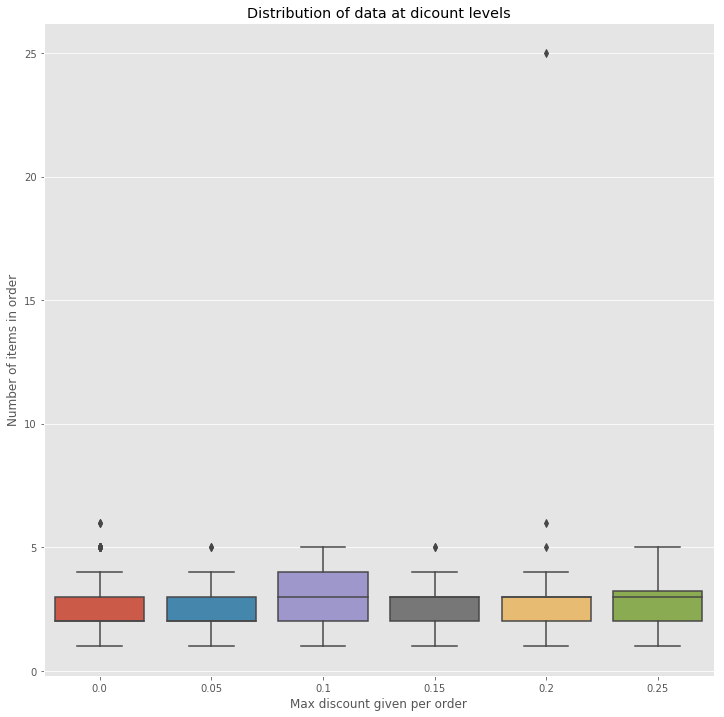

In [52]:
# Visualize Data
plt.figure(figsize=(12,12))
sns.boxplot(y='quantity',x='discount', data=df_orders)
plt.title('Distribution of data at dicount levels')
plt.xlabel('Max discount given per order')
plt.ylabel('Number of items in order');


In [53]:
# There seems to be an outlier at .2
highest = df_orders.quantity[df_orders.discount == .2].max()
dex = df_orders[df_orders.quantity == highest].index
df_orders.drop(index = dex, inplace = True)

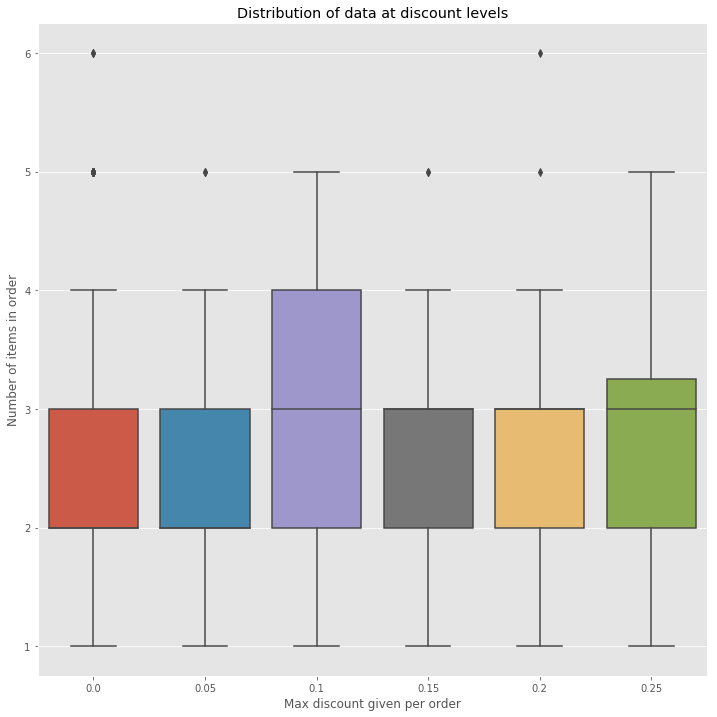

In [54]:
# Visualize again to check
plt.figure(figsize=(12,12))
sns.boxplot(y='quantity',x='discount', data=df_orders)
plt.title('Distribution of data at discount levels')
plt.xlabel('Max discount given per order')
plt.ylabel('Number of items in order');

**Null Hypothesis:** discounts have no affect on the number of products ordered by customers

**Alternate Hypothesis:** discounts have a signficant affect at alpha = .05 on the number of products ordered by customers

In [55]:
# Use ANOVA Test since this is multicomparison
results = ols('quantity ~ C(discount)', data=df_orders).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               quantity   R-squared:                       0.018
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     3.012
Date:                Fri, 19 Jul 2019   Prob (F-statistic):             0.0106
Time:                        10:44:27   Log-Likelihood:                -1230.1
No. Observations:                 829   AIC:                             2472.
Df Residuals:                     823   BIC:                             2501.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               2.4667      0.050     48.858      0.000       2.368       2.566
C(discount)[T.0.05]     0.0217      0.126      0.172      0.863      -0.226       0.269
C(discount)[T.0.1]      0.4252      0.134      3.165      0.002       0.162       0.689
C(discount)[T.0.15]     0.2400      0.134      1.797      0.073      -0.022       0.502
C(discount)[T.0.2]      0.1861      0.136      1.369      0.171      -0.081       0.453
C(discount)[T.0.25]     0.2833      0.136      2.084      0.037       0.017       0.550
==============================================================================
Omnibus:                       25.511   Durbin-Watson:                   2.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.512
Skew:                           0.418   Prob(JB):                     1.75e-06
Kurtosis:                       2.737   Cond. No.                         4.70
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since the P Value of the F statistic is less than our alpha level, we can reject the null hypothesis. 

# Hypothesis 2: Regionality

Do different regions have an effect on total revenue?

In [56]:
q = '''SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS total_bookings, c.Region as region \
FROM OrderDetail od \
LEFT JOIN [Order] o ON od.OrderId = o.Id \
LEFT JOIN Customer c ON o.CustomerId = c.Id \
GROUP BY od.OrderId'''

df_ter = pd.read_sql_query(q, engine) #puts the information from the query into a dataframe


2019-07-19 10:44:28,739 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS total_bookings, c.Region as region FROM OrderDetail od LEFT JOIN [Order] o ON od.OrderId = o.Id LEFT JOIN Customer c ON o.CustomerId = c.Id GROUP BY od.OrderId
2019-07-19 10:44:28,739 INFO sqlalchemy.engine.base.Engine ()


In [57]:
df_ter.head(15)

,OrderId,total_bookings,region
0,10248,440.0,Western Europe
1,10249,1863.4,Western Europe
2,10250,1813.0,South America
3,10251,670.8,Western Europe
4,10252,3730.0,Western Europe
5,10253,1444.8,South America
6,10254,625.2,Western Europe
7,10255,2490.5,Western Europe
8,10256,517.8,South America
9,10257,1119.9,South America


In [58]:
df_ter.region.unique()

array(['Western Europe', 'South America', 'Central America',
       'North America', 'Northern Europe', 'Scandinavia',
       'Southern Europe', 'British Isles', None, 'Eastern Europe'],
      dtype=object)

In [59]:
len(df_ter)

830

In [99]:
# check for any NAs
sum(df_ter.region.isna())

0

In [95]:
# Drop NA Region Values
df_ter.dropna()

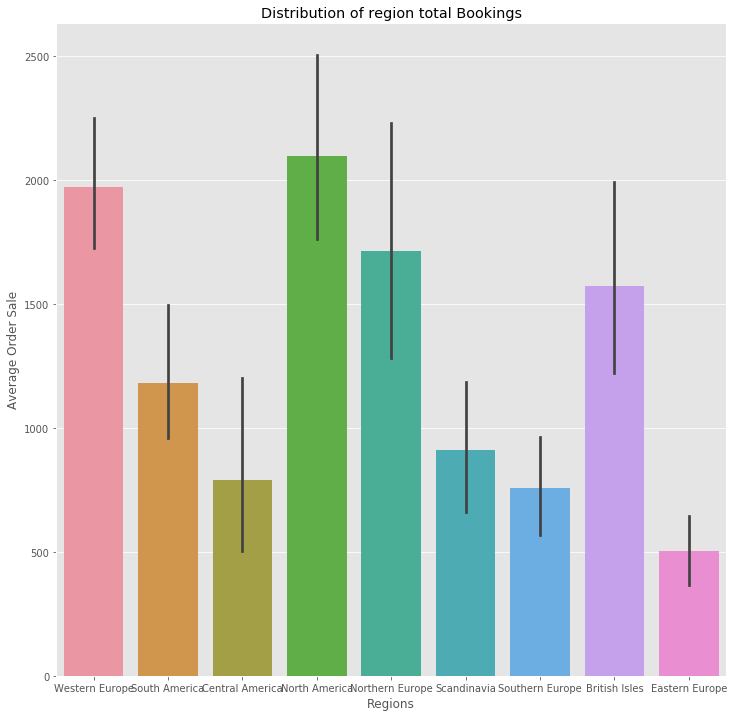

In [96]:
plt.figure(figsize=(12,12))
sns.barplot(y='total_bookings',x='region', data=df_ter)
plt.title('Distribution of region and average ')
plt.xlabel('Regions')
plt.ylabel('Average Order Sale');

Do the averages and distributions of countries differ signicantly?

In [97]:
results = ols('total_bookings ~ C(region)', data=df_ter).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_bookings   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     5.924
Date:                Fri, 19 Jul 2019   Prob (F-statistic):           2.18e-07
Time:                        11:21:31   Log-Likelihood:                -7194.3
No. Observations:                 801   AIC:                         1.441e+04
Df Residuals:                     792   BIC:                         1.445e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     1572.4520    223.535      7.034      0.000    1133.661    2011.243
C(region)[T.Central America]  -783.9710    477.938     -1.640      0.101   -1722.146     154.203
C(region)[T.Eastern Europe]  -1067.8877    765.074     -1.396      0.163   -2569.700     433.924
C(region)[T.North America]     525.5814    273.172      1.924      0.055     -10.646    1061.809
C(region)[T.Northern Europe]   142.2016    343.665      0.414      0.679    -532.401     816.804
C(region)[T.Scandinavia]      -661.2520    428.731     -1.542      0.123   -1502.836     180.332
C(region)[T.South America]    -389.6475    281.916     -1.382      0.167    -943.038     163.743
C(region)[T.Southern Europe]  -812.9881    329.430     -2.468      0.014   -1459.647    -166.329
C(region)[T.Western Europe]    398.4105    252.479      1.578      0.115     -97.197     894.018
==============================================================================
Omnibus:                      621.147   Durbin-Watson:                   2.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11665.213
Skew:                           3.417   Prob(JB):                         0.00
Kurtosis:                      20.402   Cond. No.                         13.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Regions have a significant effect on the average order size. Let's look deeper to see which regions have the largest effect

In [98]:
mc = MultiComparison(df_ter.total_bookings, df_ter.region)
mc_results = mc.tukeyhsd()
print(mc_results)

          Multiple Comparison of Means - Tukey HSD,FWER=0.05          
     group1          group2      meandiff    lower      upper   reject
----------------------------------------------------------------------
 British Isles  Central America  -783.971  -2270.5333  702.5912 False 
 British Isles   Eastern Europe -1067.8877 -3447.5483 1311.7729 False 
 British Isles   North America   525.5814  -324.0846  1375.2474 False 
 British Isles  Northern Europe  142.2016  -926.7239  1211.1272 False 
 British Isles    Scandinavia    -661.252  -1994.7633  672.2593 False 
 British Isles   South America  -389.6475  -1266.5089  487.2139 False 
 British Isles  Southern Europe -812.9881  -1837.6357  211.6595 False 
 British Isles   Western Europe  398.4105  -386.8928  1183.7138 False 
Central America  Eastern Europe -283.9167  -2911.8122 2343.9789 False 
Central America  North America  1309.5525   -92.2259  2711.3309 False 
Central America Northern Europe  926.1727  -618.3829  2470.7283 False 
Centra

NA & SA, NA and Southern Europe, SA and southern eurpoe, and Southern Europe and Western Europe were the four pairings where we reject the null.

?? Need Help interpreting this better



# Hypothesis 3 

Does the length of time you've been at the company have an effect on your average sales per month?

In [62]:
# querey employee back to order details 
# need hire date, employee ID from Employee, to link to Employee ID in Orders, 
# link Order ID from Orders to Order ID in Order Details, obtain UnitPrice X Quantity from 
# Order Details

q = '''SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS total_bookings, e.BirthDate as birth_date \
FROM OrderDetail od \
LEFT JOIN [Order] o ON od.OrderId = o.Id \
LEFT JOIN Employee e ON o.EmployeeId = e.Id \
GROUP BY e.BirthDate'''

df_age = pd.read_sql_query(q, engine)


2019-07-19 10:44:37,870 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS total_bookings, e.BirthDate as birth_date FROM OrderDetail od LEFT JOIN [Order] o ON od.OrderId = o.Id LEFT JOIN Employee e ON o.EmployeeId = e.Id GROUP BY e.BirthDate
2019-07-19 10:44:37,871 INFO sqlalchemy.engine.base.Engine ()


In [63]:
df_age.head()

,OrderId,total_bookings,birth_date
0,10250,250187.45,1969-09-19
1,10258,202143.71,1980-12-08
2,10265,177749.26,1984-02-19
3,10248,75567.75,1987-03-04
4,10262,133301.03,1990-01-09


In [64]:
len(df_age)

9

In [65]:
q = '''SELECT * FROM Employee'''

In [66]:
df_employees =  pd.read_sql_query(q, engine)
len(df_employees)

2019-07-19 10:44:40,124 INFO sqlalchemy.engine.base.Engine SELECT * FROM Employee
2019-07-19 10:44:40,125 INFO sqlalchemy.engine.base.Engine ()


9

# Hypothesis 4: Seasonality  

Is there any seasonality in sales? By Month, quarter, or weekend/weekday

In [67]:
# Query for orderid, total bookings, and order date. Connect Order Detail and Order Tables by the OrderId
q = '''SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS total_bookings, o.OrderDate as date \
FROM OrderDetail od \
LEFT JOIN [Order] o ON od.OrderId = o.Id \
GROUP BY od.OrderId'''
df_seasons = pd.read_sql_query(q, engine)


2019-07-19 10:44:41,622 INFO sqlalchemy.engine.base.Engine SELECT od.OrderId, SUM(od.UnitPrice*od.Quantity) AS total_bookings, o.OrderDate as date FROM OrderDetail od LEFT JOIN [Order] o ON od.OrderId = o.Id GROUP BY od.OrderId
2019-07-19 10:44:41,623 INFO sqlalchemy.engine.base.Engine ()


In [88]:
df_seasons.head()

,OrderId,total_bookings,date,datetime,month,day,dow,weekday,quarter
0,10248,440.0,2012-07-04,2012-07-04,7,4,2,1,3
1,10249,1863.4,2012-07-05,2012-07-05,7,5,3,1,3
2,10250,1813.0,2012-07-08,2012-07-08,7,8,6,0,3
3,10251,670.8,2012-07-08,2012-07-08,7,8,6,0,3
4,10252,3730.0,2012-07-09,2012-07-09,7,9,0,1,3


In [69]:
import datetime

In [70]:
#change date into datetime object
dates = []
for i in df_seasons.date:
    ii = datetime.datetime.strptime(i, "%Y-%m-%d")
    dates.append(ii)
df_seasons['datetime'] = dates

In [80]:
# Turn order dates into months and days
months = []
for i in df_seasons.datetime:
    months.append(i.month)
df_seasons['month'] = months

day = []
for k in df_seasons.datetime:
    day.append(k.day)
df_seasons['day'] = day

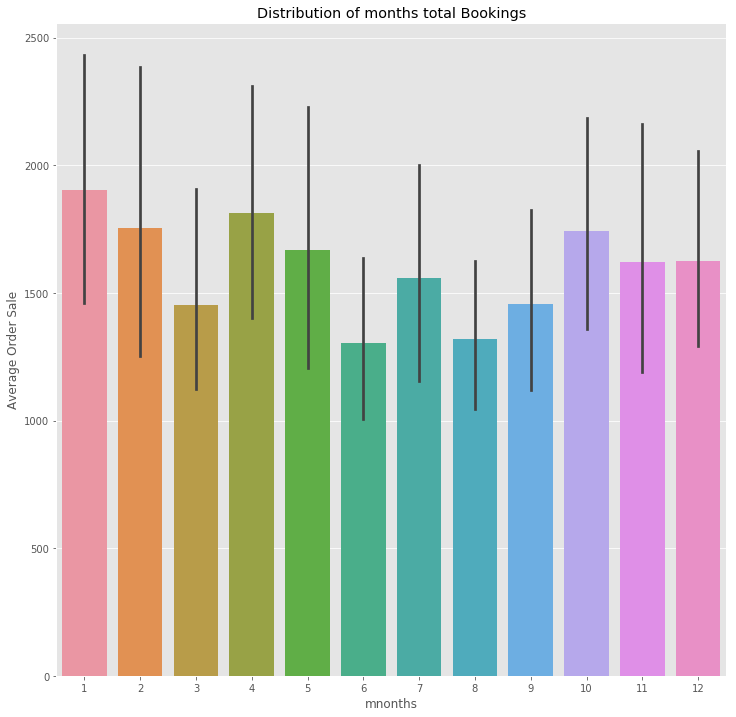

In [72]:
plt.figure(figsize=(12,12))
sns.barplot(y='total_bookings',x='month', data=df_seasons)
plt.title('Distribution of months total Bookings')
plt.xlabel('mnonths')
plt.ylabel('Average Order Sale');

/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Text(0, 0.5, 'Density')

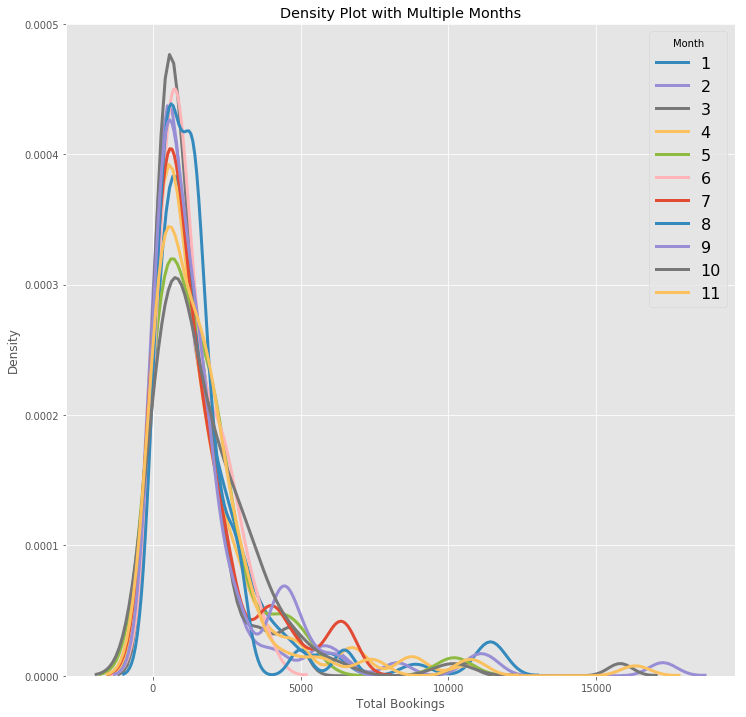

In [73]:
# Do overlapping distribtion Plot on monthly data
plt.figure(figsize=(12,12))
for i in range(0,12):
    # Subset to the airline
    subset = df_seasons[df_seasons['month'] == i]
    
    # Draw the density plot
    sns.distplot(subset['total_bookings'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = i)
    
# Plot formatting
plt.legend(prop={'size': 16}, title = 'Month')
plt.title('Density Plot with Multiple Months')
plt.xlabel('Total Bookings')
plt.ylabel('Density')

In [100]:
results = ols('total_bookings ~ C(month)', data=df_seasons).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_bookings   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.6015
Date:                Fri, 19 Jul 2019   Prob (F-statistic):              0.829
Time:                        12:00:57   Log-Likelihood:                -7478.7
No. Observations:                 830   AIC:                         1.498e+04
Df Residuals:                     818   BIC:                         1.504e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept       1903.9491    212.763      8.949      0.000    1486.322    2321.576
C(month)[T.2]   -147.6943    305.391     -0.484      0.629    -747.136     451.748
C(month)[T.3]   -449.5282    289.731     -1.552      0.121   -1018.232     119.176
C(month)[T.4]    -91.2829    288.457     -0.316      0.752    -657.486     474.920
C(month)[T.5]   -236.0717    363.137     -0.650      0.516    -948.862     476.719
C(month)[T.6]   -601.0158    421.966     -1.424      0.155   -1429.279     227.248
C(month)[T.7]   -346.5485    343.071     -1.010      0.313   -1019.951     326.854
C(month)[T.8]   -583.4131    337.567     -1.728      0.084   -1246.012      79.186
C(month)[T.9]   -447.7988    334.158     -1.340      0.181   -1103.708     208.110
C(month)[T.10]  -161.2600    327.891     -0.492      0.623    -804.866     482.346
C(month)[T.11]  -283.3159    335.838     -0.844      0.399    -942.522     375.890
C(month)[T.12]  -278.2572    309.344     -0.900      0.369    -885.459     328.944
==============================================================================
Omnibus:                      636.870   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10981.068
Skew:                           3.412   Prob(JB):                         0.00
Kurtosis:                      19.461   Cond. No.                         11.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [85]:
# Add Quarters to see if average order size changes over quarters
quarters = []
for i in df_seasons.month:
    if i in (1,2,3):
        q =1
    if i in (4, 5, 6):
        q = 2
    if i in (7,8,9):
        q = 3
    if i in (10, 11, 12):
        q = 4
    quarters.append(q)
df_seasons['quarter'] = quarters

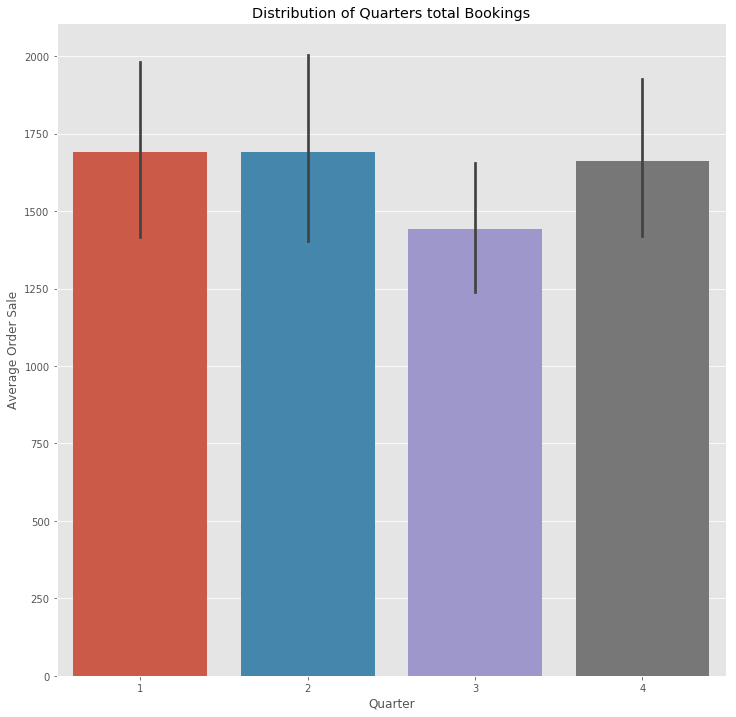

In [86]:
plt.figure(figsize=(12,12))
sns.barplot(y='total_bookings',x='quarter', data=df_seasons)
plt.title('Distribution of Quarters total Bookings')
plt.xlabel('Quarter')
plt.ylabel('Average Order Sale');

It looks like Q3 had a lower than average sales price. Let's see if changes in quarter has a significant effect on the average order price. 

**Null Hypothesis**: Changes in quarter has no significant effect on the average order price

**Alternate Hypothesis**: Changes in quarter has a significant effect on the average order price

In [87]:
results = ols('total_bookings ~ C(quarter)', data=df_seasons).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_bookings   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6661
Date:                Fri, 19 Jul 2019   Prob (F-statistic):              0.573
Time:                        11:07:38   Log-Likelihood:                -7481.1
No. Observations:                 830   AIC:                         1.497e+04
Df Residuals:                     826   BIC:                         1.499e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        1690.2264    120.330     14.047      0.000    1454.038    1926.415
C(quarter)[T.2]     1.1566    190.783      0.006      0.995    -373.321     375.634
C(quarter)[T.3]  -247.3527    193.422     -1.279      0.201    -627.008     132.303
C(quarter)[T.4]   -28.9436    184.715     -0.157      0.876    -391.510     333.622
==============================================================================
Omnibus:                      639.712   Durbin-Watson:                   2.028
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11026.036
Skew:                           3.435   Prob(JB):                         0.00
Kurtosis:                      19.481   Cond. No.                         4.28
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

With a p value at .5, we do not reject the null hypothesis. Although there is an obervational difference between the means, there is no significant effect of quarter on average sales order

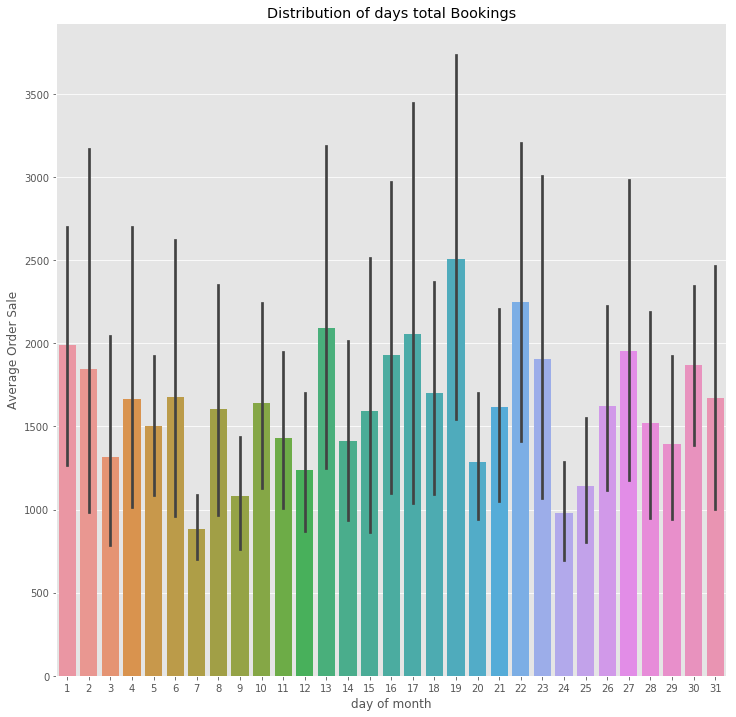

In [74]:
plt.figure(figsize=(12,12))
sns.barplot(y='total_bookings',x='day', data=df_seasons)
plt.title('Distribution of days total Bookings')
plt.xlabel('day of month')
plt.ylabel('Average Order Sale');

It seems like there is a weekly pattern - let's look into days of the week to see if there is a significant effect

In [81]:
# Do certain days of the week affect sales?
dow = []
for i in df_seasons.datetime:
    w = i.weekday()
    dow.append(w)
df_seasons['dow'] = dow


In [82]:
df_seasons.dow.value_counts()

2    168
0    168
6    165
1    165
3    164
Name: dow, dtype: int64

Since this is a sample database, i'm assuming that the missing values (4,5) refer to Saturday and Sunday (even though saturday and sunday correspond to 5 &6), and that sales are only placed during the week

Let's visualize the data 

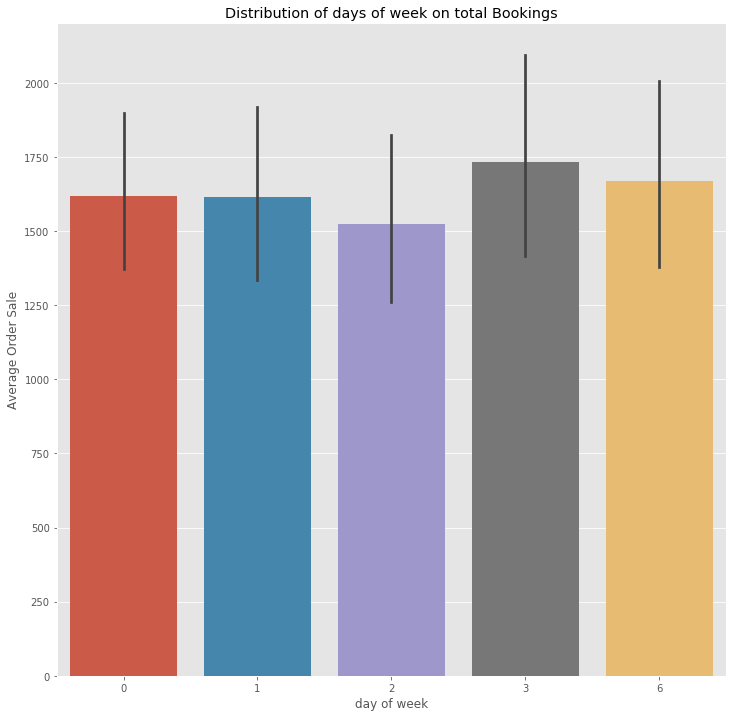

In [83]:
plt.figure(figsize=(12,12))
sns.barplot(y='total_bookings',x='dow', data=df_seasons)
plt.title('Distribution of days of week on total Bookings')
plt.xlabel('day of week')
plt.ylabel('Average Order Sale');

**Null Hypothesis**: There is no significant difference between the days of the week and the average order size

**Alternative Hypothesis**: the day of the week has a significant effect on the average order size

In [84]:
results = ols('total_bookings ~ C(dow)', data=df_seasons).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         total_bookings   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.2472
Date:                Fri, 19 Jul 2019   Prob (F-statistic):              0.911
Time:                        10:57:11   Log-Likelihood:                -7481.6
No. Observations:                 830   AIC:                         1.497e+04
Df Residuals:                     825   BIC:                         1.500e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept    1619.7218    153.859     10.527      0.000    1317.721    1921.723
C(dow)[T.1]    -4.2581    218.576     -0.019      0.984    -433.289     424.773
C(dow)[T.2]   -95.0596    217.589     -0.437      0.662    -522.153     332.034
C(dow)[T.3]   114.3857    218.912      0.523      0.601    -315.304     544.076
C(dow)[T.6]    48.5018    218.576      0.222      0.824    -380.529     477.533
==============================================================================
Omnibus:                      642.575   Durbin-Watson:                   2.023
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            11171.031
Skew:                           3.455   Prob(JB):                         0.00
Kurtosis:                      19.592   Cond. No.                         5.80
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Since the p value of the F statistic is so high, we do not reject the null and conclude that day of the week has no significant effect on the average order size